In [2]:
# Загружаем данные
df = Reader.read_csv('./dataset/df_lowcost.csv')


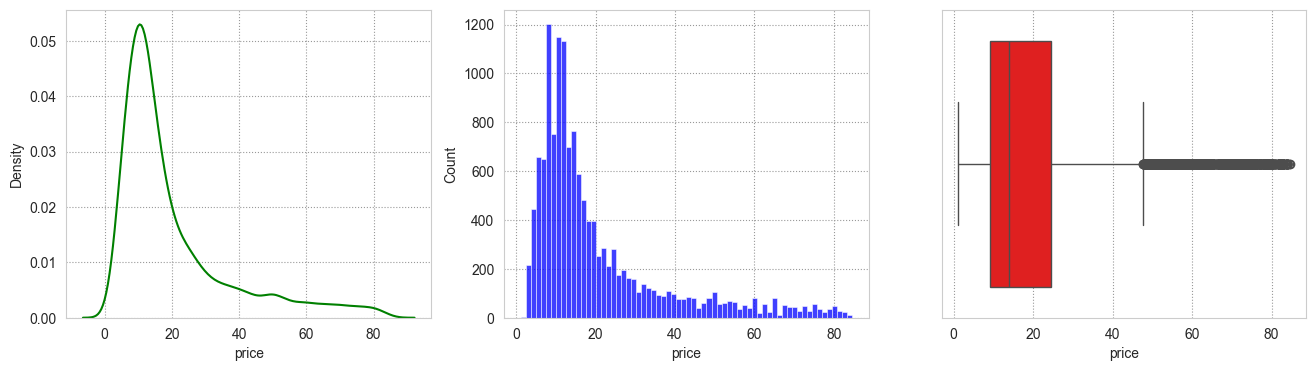

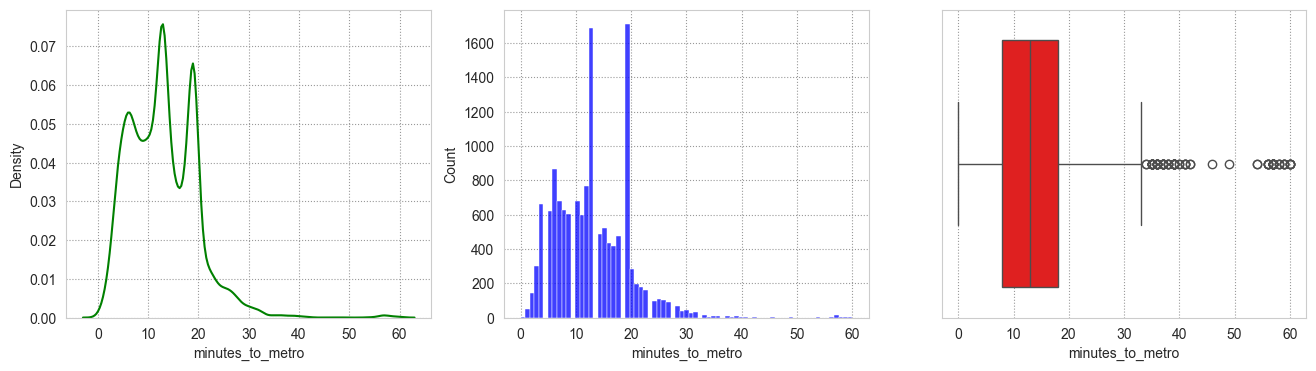

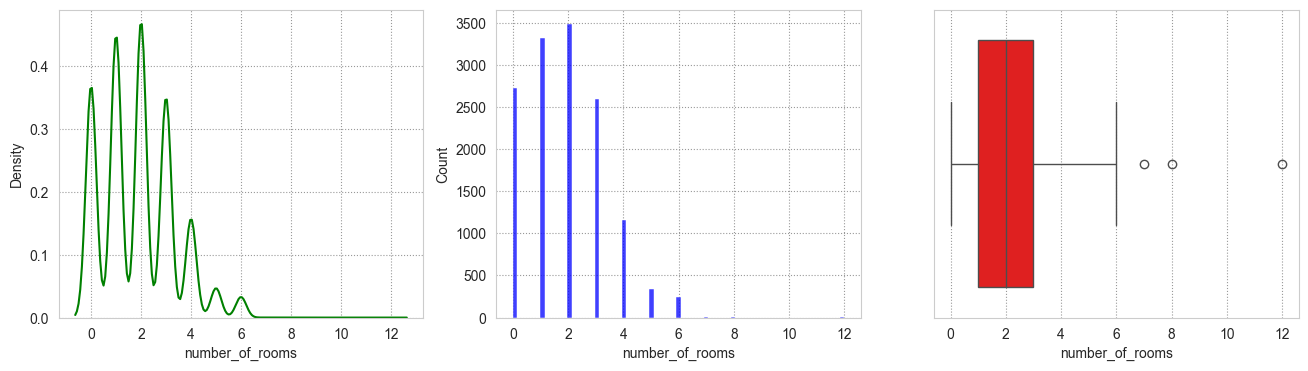

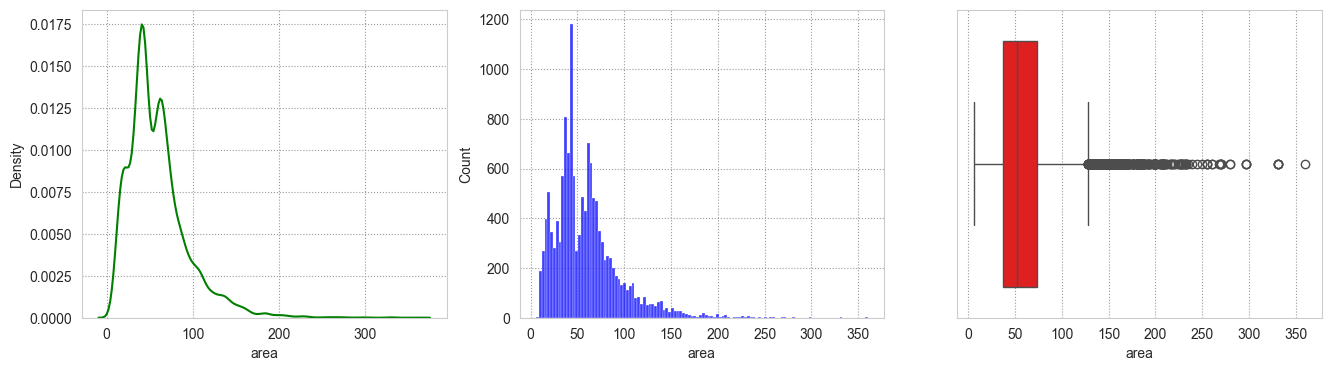

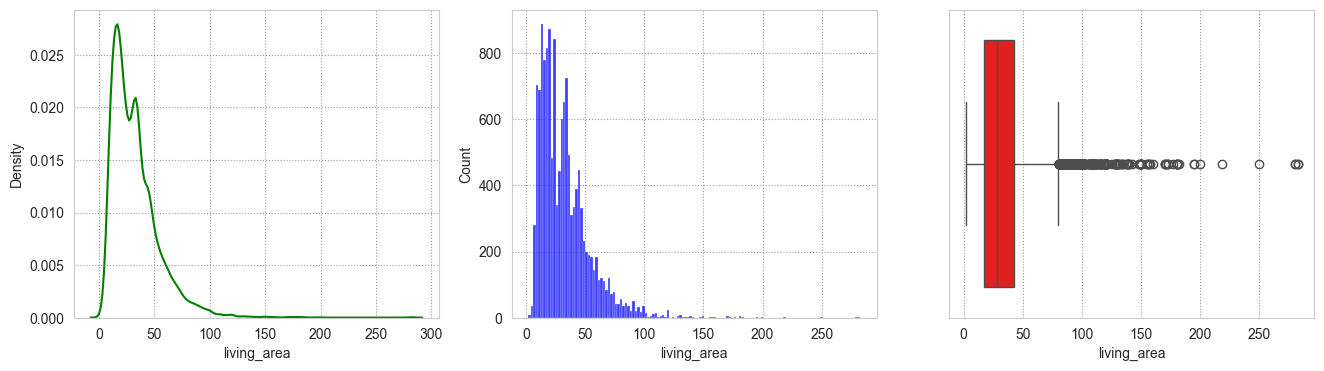

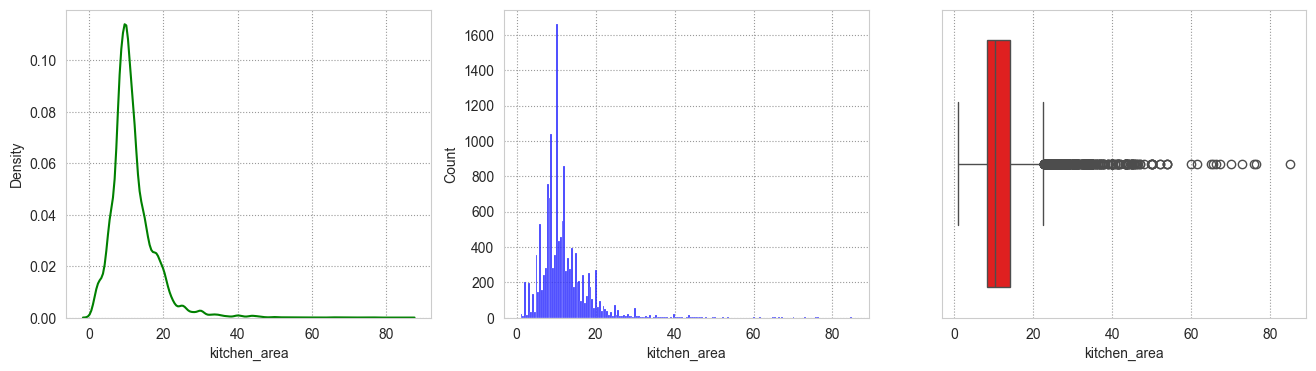

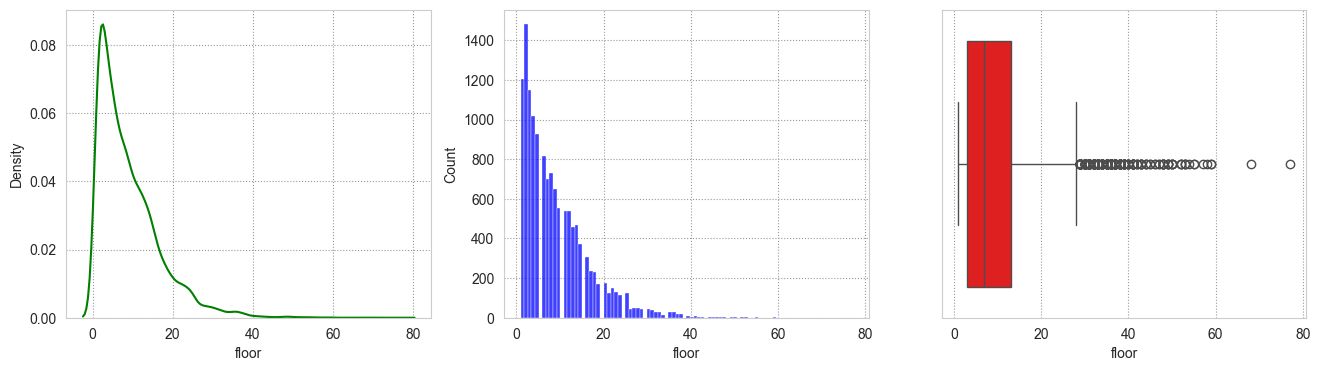

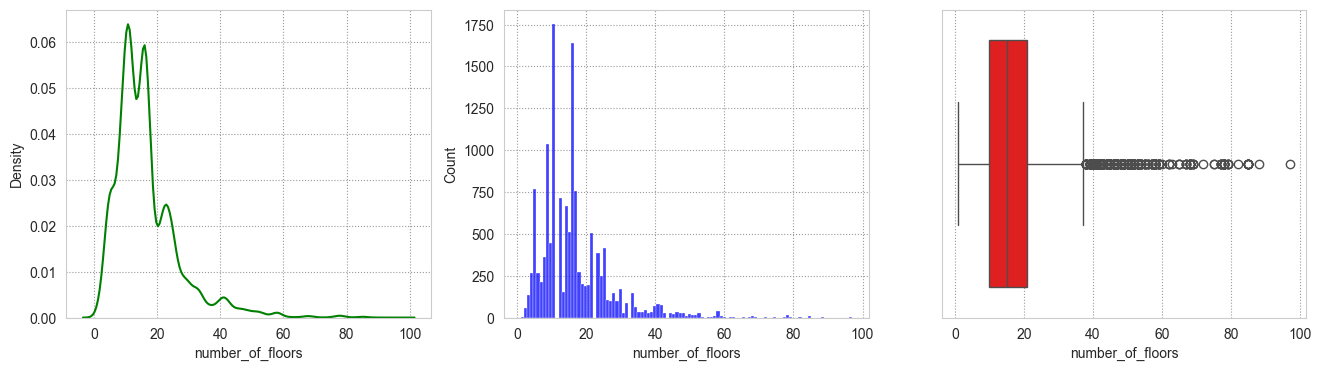

In [3]:
# ещё раз визуально оцениваем обычную недвижимость
Drawer.draw_kde_hist_boxplot(df)

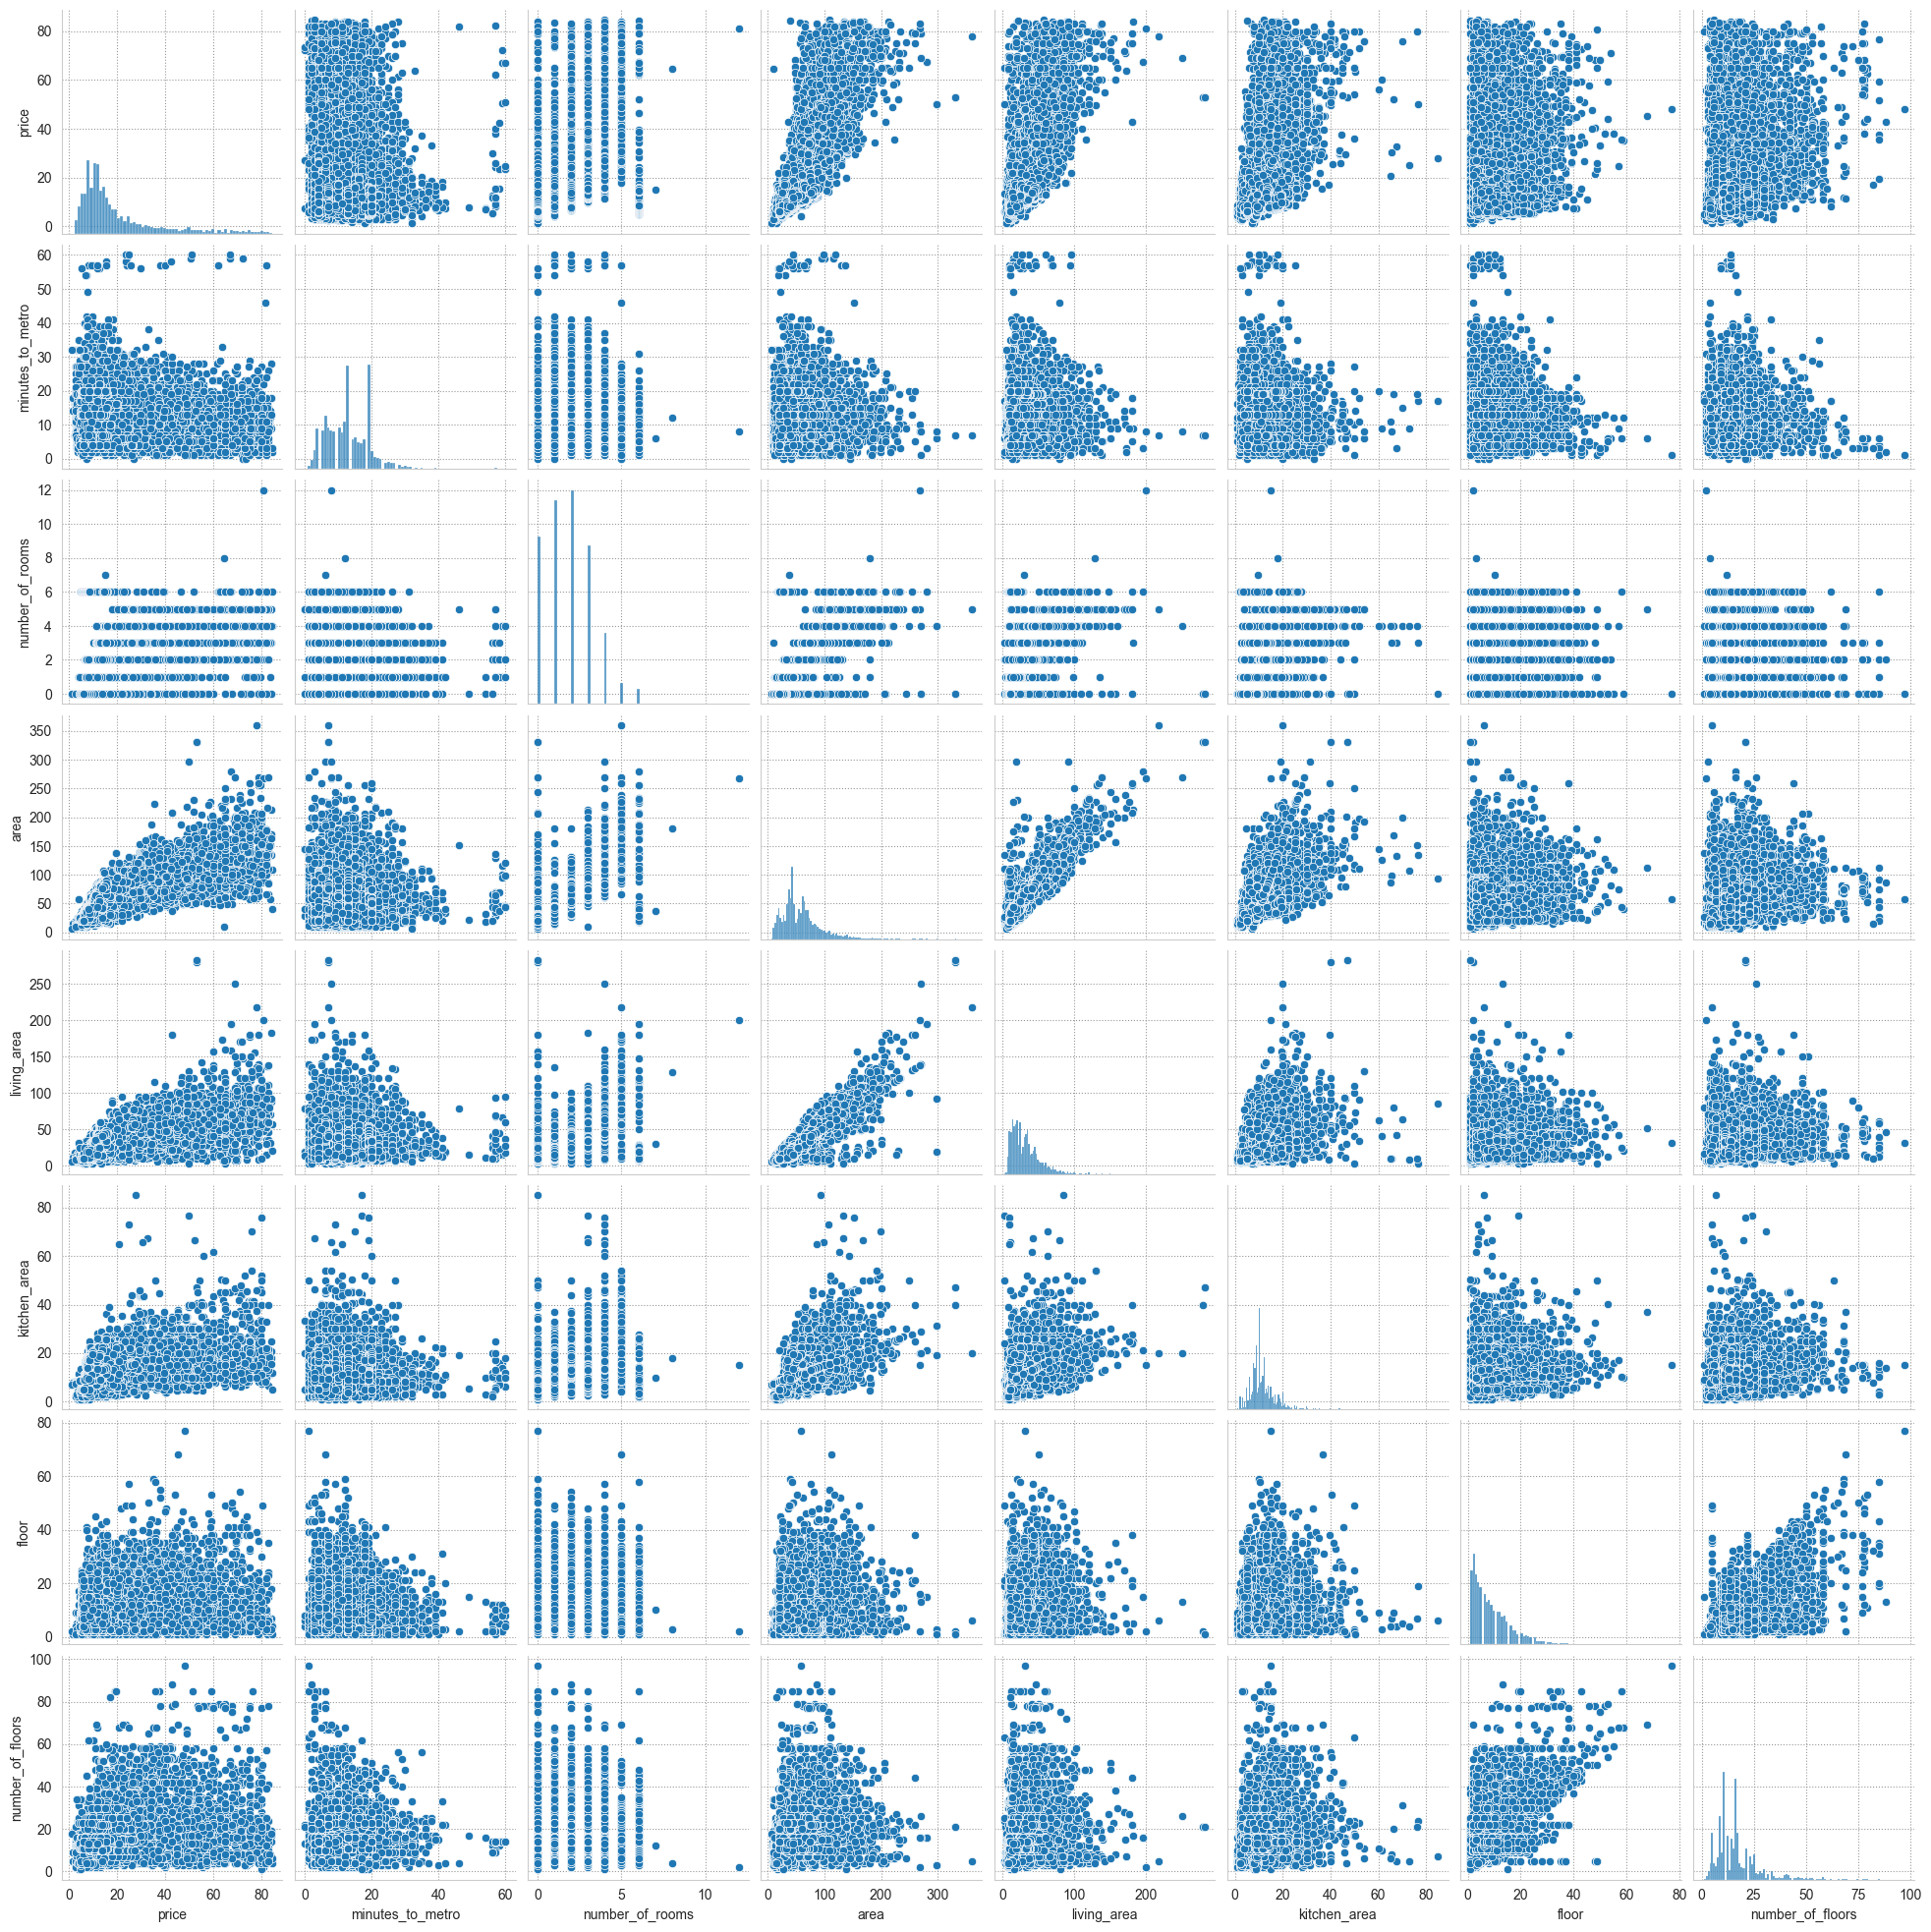

In [4]:
# Исследуем графически зависимость признаков на целевую переменную недвижимости
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

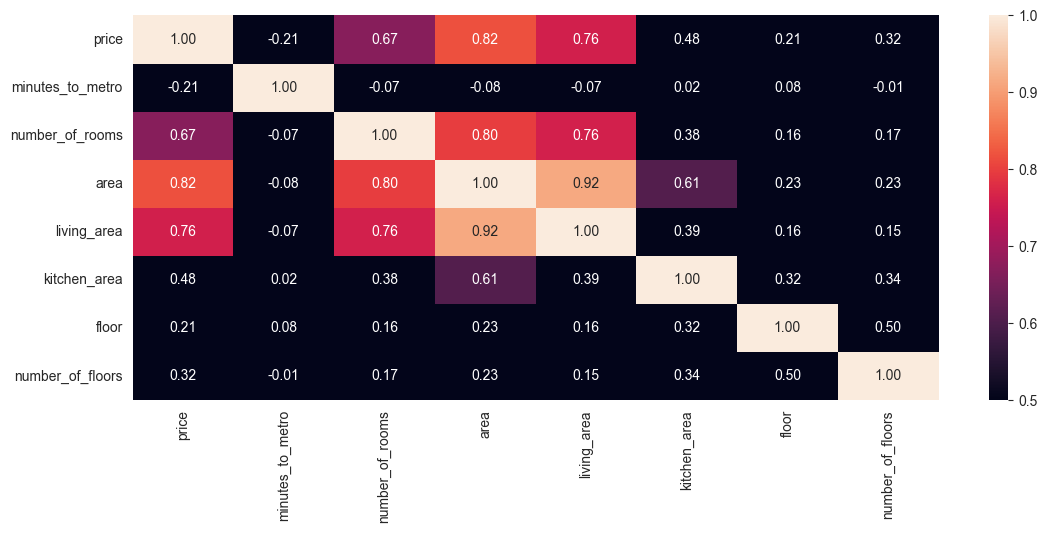

In [5]:
# Исследуем тепловую карту корреляции признаков на целевую переменную для обычной недвижимости
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True, fmt='.2f', vmin=0.5)
plt.show()

Выводы:
1. графически наблюдается связь цены квартиры от площади.
2. наблюдается корреляция признаков: площадь (area) коррелирует с жилой площадью (living_area) и с площадью кухни (kitchen_area), также числом комнат (number_of_rooms), что избыточно и в дальнейшем можно удалить эти колонки при обнаружении между ними сильной VIF.

In [6]:
# Проверим допущение о мультиколлинеарности
numeric_col = df.drop(columns='price').describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.962052
number_of_rooms,5.330253
area,40.328189
living_area,23.031125
kitchen_area,8.434223
floor,3.557501
number_of_floors,4.906106


In [7]:
# Проверим допущение о мультиколлинеарности ещё раз
numeric_col = df.drop(columns=['price', 'living_area', 'kitchen_area', 'number_of_rooms']).describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.670982
area,3.196631
floor,3.532578
number_of_floors,4.702908


Вывод: для обычной недвижимости четыре признака оказались менее 5, то есть с этими признаками можно работать

In [8]:
# Смотрим на колонки с категориальными переменными
df.describe(include='object')

,apartment_type,metro_station,renovation
count,13873,13873,13873
unique,2,531,4
top,Secondary,Депо,Cosmetic
freq,10260,1646,6439


Выводы:
1. у нас всего 2 типа аппартаментов в датасете
2. у нас всего 4 вида ремонта в датасете
3. станций метро в москве слишком много (вся россия работает на благоустройство москвы)

In [9]:
StatCriteria().mannwhitneyu(df, 'apartment_type', 'price')

Mann-Whitney U test
U_statistic = 27560809.5
Распределения двух выборок не равны (p-value = 0.000).


(np.float64(27560809.5), np.float64(0.0))

In [10]:
StatCriteria().kruskal(df, 'metro_station', 'price')

kruskal
statistic = 7629.413295552101
Медианы всех групп не равны (p-value = 0.000).


(np.float64(7629.413295552101), np.float64(0.0))

In [11]:
StatCriteria().kruskal(df, 'renovation', 'price')

kruskal
statistic = 3241.753938350828
Медианы всех групп не равны (p-value = 0.000).


(np.float64(3241.753938350828), np.float64(0.0))

Вывод: на стоимость lowcost недвижимости влияют все категориальные переменные такие как:
1. apartment_type,
2. metro_station,
3. renovation

поэтому их все придётся учитывать при проведении регрессии.

In [12]:
df['apartment_type'] = Encoder().bolean_one_column_encoder(df['apartment_type'], 'Secondary')
df['metro_station'] = Encoder().leaveOneOutEncoder(df['metro_station'], df['price'])
df['renovation'] = Encoder().labelEncoder(df['renovation'])

In [13]:
# проверяем датасет
df.head(5)

,price,apartment_type,metro_station,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
0,53.00,1,58.381684,9,3,96.9,59.0,11.1,2,5,3
1,44.24,1,41.514126,6,3,63.2,34.1,11.9,40,41,1
2,47.00,1,48.612600,9,3,103.8,59.0,15.0,6,6,3
3,67.99,1,47.738017,6,3,111.0,40.0,15.8,5,6,1
4,52.50,1,30.917827,11,3,92.0,70.0,20.0,4,21,0


In [14]:
# подготавливаем данные
exclude_features = ['price', 'apartment_type', 'living_area', 'kitchen_area', 'number_of_rooms']
target = ['price']
X_train, X_test, y_train, y_test = DataPreparation().prepare_data(df, exclude_features, target)

In [15]:
# проводим нормализацию (логарифмирование)
X_train, X_test, y_train, y_test = Normalizer().log_norm(X_train, X_test, y_train, y_test)

In [16]:
# Применяем готовую линейную регрессию из библиотеки statsmodels

# Добавим константу как требование OLS
X_train_plus_const = sm.add_constant(X_train, prepend=False)
X_test_plus_const = sm.add_constant(X_test, prepend=False)

# Обучаем модель на обучающей выборке
model = OLS(y_train, X_train_plus_const).fit()

# Прогнозируем на тестовой выборке
y_pred = model.predict(X_test_plus_const)

residuals = y_test.flatten() - y_pred
print(model.summary())

MetricCalculator.show_metrics(y_test.flatten(), y_pred)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                 1.470e+04
Date:                Sun, 26 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:38:33   Log-Likelihood:                 930.49
No. Observations:               10404   AIC:                            -1847.
Df Residuals:                   10397   BIC:                            -1796.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
metro_station        0.5249      0.005  

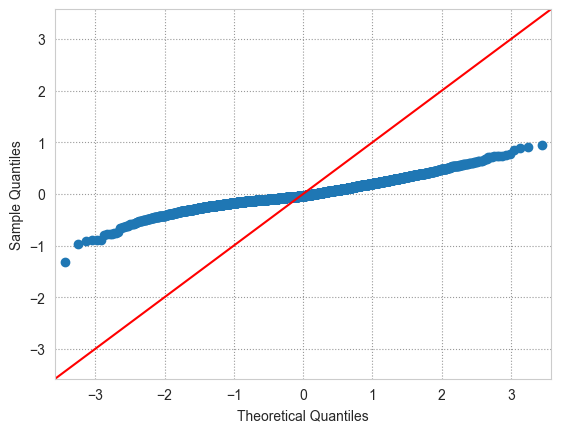

In [17]:
# Проверка на нормальность остатков
fig = sm.qqplot(residuals, line='45')
plt.show()

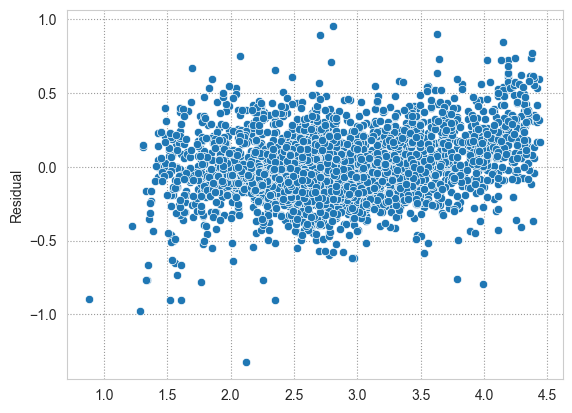

In [18]:
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.flatten(), y = residuals)
plt.ylabel("Residual")
plt.show()

In [19]:
# Применяем Lasso регрессию
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

# Прогнозируем на тестовой выборке
y_pred = lasso.predict(X_test)

residuals = y_test.flatten() - y_pred

print("Коэффициенты Lasso-регрессии:", lasso.coef_)

MetricCalculator.show_metrics(y_test, y_pred)

Коэффициенты Lasso-регрессии: [ 0.5162416  -0.02448613  0.75044827  0.01426883  0.03852265  0.10906658]
MAE: 0.16425141779641508
RMSE: 0.21349015247071038


Выводы: не влияют minutes_to_metro, floor, number_of_floor